# Jonathan Halverson
# Saturday, February 10, 2018
# Home prices in California in Spark 2

In this notebook we create regression models for home prices.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()

In [3]:
housing_raw = spark.read.csv('Sacramentorealestatetransactions.csv', inferSchema=True, header=True)
housing_raw = housing_raw.withColumnRenamed('sq__ft', 'sqft')
all_wo_date = housing_raw.columns
all_wo_date.remove('sale_date')
housing_raw.select(all_wo_date).show(5)

+----------------+----------+-----+-----+----+-----+----+-----------+-----+---------+-----------+
|          street|      city|  zip|state|beds|baths|sqft|       type|price| latitude|  longitude|
+----------------+----------+-----+-----+----+-----+----+-----------+-----+---------+-----------+
|    3526 HIGH ST|SACRAMENTO|95838|   CA|   2|    1| 836|Residential|59222|38.631913|-121.434879|
|     51 OMAHA CT|SACRAMENTO|95823|   CA|   3|    1|1167|Residential|68212|38.478902|-121.431028|
|  2796 BRANCH ST|SACRAMENTO|95815|   CA|   2|    1| 796|Residential|68880|38.618305|-121.443839|
|2805 JANETTE WAY|SACRAMENTO|95815|   CA|   2|    1| 852|Residential|69307|38.616835|-121.439146|
| 6001 MCMAHON DR|SACRAMENTO|95824|   CA|   2|    1| 797|Residential|81900| 38.51947|-121.435768|
+----------------+----------+-----+-----+----+-----+----+-----------+-----+---------+-----------+
only showing top 5 rows



In [4]:
housing_raw.toPandas().head(3).T

,0,1,2
street,3526 HIGH ST,51 OMAHA CT,2796 BRANCH ST
city,SACRAMENTO,SACRAMENTO,SACRAMENTO
zip,95838,95823,95815
state,CA,CA,CA
beds,2,3,2
baths,1,1,1
sqft,836,1167,796
type,Residential,Residential,Residential
sale_date,Wed May 21 00:00:00 EDT 2008,Wed May 21 00:00:00 EDT 2008,Wed May 21 00:00:00 EDT 2008
price,59222,68212,68880


In [5]:
from pyspark.sql.functions import to_timestamp
housing = housing_raw.withColumn('sale_date', to_timestamp('sale_date', 'EEE MMM d H:mm:ss z yyyy'))

In [6]:
housing.printSchema()

root
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- sqft: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- sale_date: timestamp (nullable = true)
 |-- price: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [7]:
housing.groupBy('sale_date').count().show()

+-------------------+-----+
|          sale_date|count|
+-------------------+-----+
|2008-05-19 00:00:00|  268|
|2008-05-21 00:00:00|  158|
|2008-05-15 00:00:00|  118|
|2008-05-16 00:00:00|  264|
|2008-05-20 00:00:00|  177|
+-------------------+-----+



In [8]:
housing.select('beds', 'baths', 'sqft', 'price', 'latitude').describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|              beds|             baths|              sqft|             price|           latitude|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|               985|               985|               985|               985|                985|
|   mean|2.9116751269035532|1.7766497461928934|1314.9167512690356|234144.26395939087| 38.607732086294504|
| stddev|1.3079322320435807|0.8953714223186463| 853.0482425034448|138365.83908492787|0.14543287915296987|
|    min|                 0|                 0|                 0|              1551|          38.241514|
|    max|                 8|                 5|              5822|            884790|          39.020808|
+-------+------------------+------------------+------------------+------------------+-------------------+



In [9]:
housing.count()

985

In [10]:
housing.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
street       985 non-null object
city         985 non-null object
zip          985 non-null int64
state        985 non-null object
beds         985 non-null int64
baths        985 non-null int64
sqft         985 non-null int64
type         985 non-null object
sale_date    985 non-null datetime64[ns]
price        985 non-null int64
latitude     985 non-null float64
longitude    985 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 92.4+ KB


There is probably some information in street but we drop it for simplicity:

In [11]:
housing = housing.drop('state', 'street')

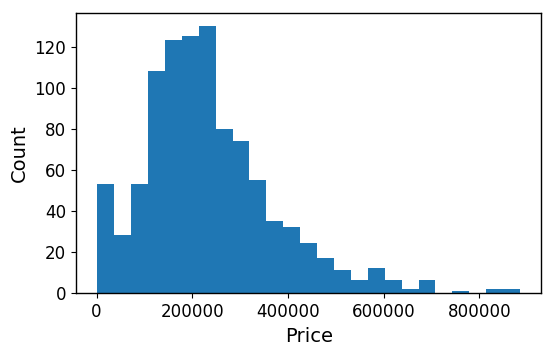

In [12]:
plt.hist(housing.select('price').rdd.map(lambda x: x[0]).collect(), bins=25)
plt.xlabel('Price')
plt.ylabel('Count')

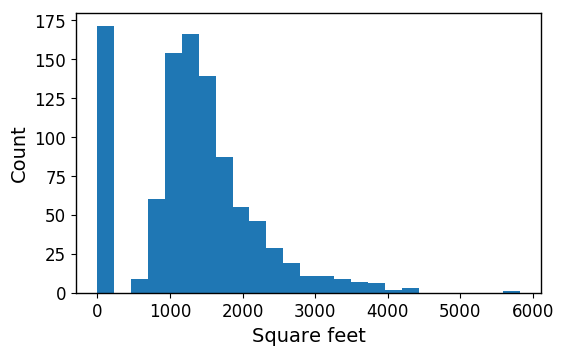

In [13]:
plt.hist(housing.select('sqft').rdd.map(lambda x: x[0]).collect(), bins=25)
plt.xlabel('Square feet')
plt.ylabel('Count')

Let's clean the data by removing any entries where sqft is zero:

In [14]:
housing = housing.filter(housing.sqft > 0)

In [15]:
housing.count()

814

In [16]:
housing.groupBy('baths').count().orderBy('baths').show()

+-----+-----+
|baths|count|
+-----+-----+
|    1|  179|
|    2|  507|
|    3|  110|
|    4|   17|
|    5|    1|
+-----+-----+



In [17]:
housing.groupBy('beds').count().orderBy('beds').show()

+----+-----+
|beds|count|
+----+-----+
|   1|   10|
|   2|  125|
|   3|  392|
|   4|  235|
|   5|   49|
|   6|    2|
|   8|    1|
+----+-----+



In [18]:
housing.groupBy('type').count().orderBy('type').show()

+------------+-----+
|        type|count|
+------------+-----+
|       Condo|   42|
|Multi-Family|   13|
| Residential|  759|
+------------+-----+



In [19]:
housing = housing.withColumn('total_rooms', housing.beds + housing.baths)
housing.select('beds', 'baths', 'total_rooms', 'price').show()

+----+-----+-----------+------+
|beds|baths|total_rooms| price|
+----+-----+-----------+------+
|   2|    1|          3| 59222|
|   3|    1|          4| 68212|
|   2|    1|          3| 68880|
|   2|    1|          3| 69307|
|   2|    1|          3| 81900|
|   3|    1|          4| 89921|
|   3|    2|          5| 90895|
|   3|    1|          4| 91002|
|   2|    2|          4| 94905|
|   3|    2|          5| 98937|
|   3|    2|          5|100309|
|   3|    2|          5|106250|
|   1|    1|          2|106852|
|   3|    1|          4|107502|
|   2|    2|          4|108750|
|   2|    2|          4|110700|
|   2|    1|          3|113263|
|   2|    1|          3|116250|
|   2|    1|          3|120000|
|   3|    2|          5|121630|
+----+-----+-----------+------+
only showing top 20 rows



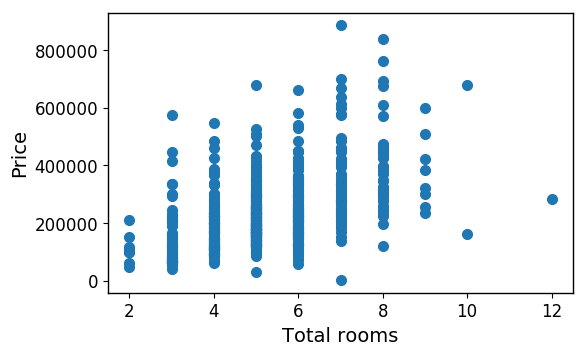

In [20]:
x = housing.rdd.map(lambda row: row.total_rooms).collect()
y = housing.rdd.map(lambda row: row.price).collect()
plt.scatter(x, y)
plt.xlabel('Total rooms')
plt.ylabel('Price')

In [21]:
import numpy as np
np.cov(x, y) / np.std(x) / np.std(y)

array([[  1.15846307e-05,   5.14726196e-01],
       [  5.14726196e-01,   8.65337502e+04]])

In [22]:
from pyspark.sql import functions as F
housing.groupBy('city').agg(F.avg('price'), F.min('price'), F.max('price'), F.count('*')).orderBy('avg(price)').show(100)

+---------------+------------------+----------+----------+--------+
|           city|        avg(price)|min(price)|max(price)|count(1)|
+---------------+------------------+----------+----------+--------+
|    SLOUGHHOUSE|            2000.0|      2000|      2000|       1|
|        ELVERTA|          132866.0|    126000|    140000|       4|
|NORTH HIGHLANDS|135659.33333333334|     63000|    224252|      21|
|WEST SACRAMENTO|          147000.0|    147000|    147000|       1|
|      RIO LINDA|184621.58333333334|     98937|    300000|      12|
| CITRUS HEIGHTS|187114.91428571427|     30000|    305000|      35|
|     SACRAMENTO|194560.95283018867|     40000|    699000|     424|
|DIAMOND SPRINGS|          216033.0|    216033|    216033|       1|
|   MEADOW VISTA|          230000.0|    230000|    230000|       1|
|           GALT|          231040.6|    106716|    420000|      20|
|       ANTELOPE|232496.39393939395|    115000|    408431|      33|
| RANCHO CORDOVA|235065.04761904763|     94905| 

Convert the type feature to a stringindex then make one-hot with P-1 dummies, not P:

In [23]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

str_idx = StringIndexer(inputCol="type", outputCol="type_idx")
model = str_idx.fit(housing)
housing = model.transform(housing)

ohe = OneHotEncoder(inputCol="type_idx", outputCol="type_ohe", dropLast=False)
housing = ohe.transform(housing)
housing.select('type', 'type_idx', 'type_ohe', 'price').show()

+-----------+--------+-------------+------+
|       type|type_idx|     type_ohe| price|
+-----------+--------+-------------+------+
|Residential|     0.0|(3,[0],[1.0])| 59222|
|Residential|     0.0|(3,[0],[1.0])| 68212|
|Residential|     0.0|(3,[0],[1.0])| 68880|
|Residential|     0.0|(3,[0],[1.0])| 69307|
|Residential|     0.0|(3,[0],[1.0])| 81900|
|      Condo|     1.0|(3,[1],[1.0])| 89921|
|Residential|     0.0|(3,[0],[1.0])| 90895|
|Residential|     0.0|(3,[0],[1.0])| 91002|
|      Condo|     1.0|(3,[1],[1.0])| 94905|
|Residential|     0.0|(3,[0],[1.0])| 98937|
|Residential|     0.0|(3,[0],[1.0])|100309|
|Residential|     0.0|(3,[0],[1.0])|106250|
|Residential|     0.0|(3,[0],[1.0])|106852|
|Residential|     0.0|(3,[0],[1.0])|107502|
|Residential|     0.0|(3,[0],[1.0])|108750|
|      Condo|     1.0|(3,[1],[1.0])|110700|
|Residential|     0.0|(3,[0],[1.0])|113263|
|      Condo|     1.0|(3,[1],[1.0])|116250|
|Residential|     0.0|(3,[0],[1.0])|120000|
|Residential|     0.0|(3,[0],[1.

In [24]:
housing.groupBy('city').pivot('baths', [1, 2, 3]).avg('price').orderBy('city').show(10)

+---------------+-----------------+------------------+-----------------+
|           city|                1|                 2|                3|
+---------------+-----------------+------------------+-----------------+
|       ANTELOPE|         223139.0|        212704.625|       293041.375|
|         AUBURN|             null|          272500.0|         420454.0|
|   CAMERON PARK|             null|          399000.0|             null|
|     CARMICHAEL|         212218.0|          293097.2|         668365.0|
| CITRUS HEIGHTS|147464.2857142857|         195035.28|         192418.0|
|           COOL|             null|          300000.0|             null|
|DIAMOND SPRINGS|             null|          216033.0|             null|
|      EL DORADO|         205000.0|          289000.0|             null|
|EL DORADO HILLS|             null| 299412.6666666667|             null|
|      ELK GROVE|89666.66666666667|239681.41666666666|346359.1379310345|
+---------------+-----------------+----------------

In [25]:
housing.groupBy('city', 'baths').avg('price').orderBy('city').show(10)

+--------------+-----+----------+
|          city|baths|avg(price)|
+--------------+-----+----------+
|      ANTELOPE|    1|  223139.0|
|      ANTELOPE|    2|212704.625|
|      ANTELOPE|    3|293041.375|
|        AUBURN|    3|  420454.0|
|        AUBURN|    2|  272500.0|
|  CAMERON PARK|    2|  399000.0|
|    CARMICHAEL|    2|  293097.2|
|    CARMICHAEL|    3|  668365.0|
|    CARMICHAEL|    1|  212218.0|
|CITRUS HEIGHTS|    3|  192418.0|
+--------------+-----+----------+
only showing top 10 rows



In [26]:
housing.where("city == 'SACRAMENTO'").select('city', 'price').show()

+----------+------+
|      city| price|
+----------+------+
|SACRAMENTO| 59222|
|SACRAMENTO| 68212|
|SACRAMENTO| 68880|
|SACRAMENTO| 69307|
|SACRAMENTO| 81900|
|SACRAMENTO| 89921|
|SACRAMENTO| 90895|
|SACRAMENTO| 91002|
|SACRAMENTO|100309|
|SACRAMENTO|106250|
|SACRAMENTO|106852|
|SACRAMENTO|107502|
|SACRAMENTO|108750|
|SACRAMENTO|110700|
|SACRAMENTO|120000|
|SACRAMENTO|122682|
|SACRAMENTO|124100|
|SACRAMENTO|127281|
|SACRAMENTO|129000|
|SACRAMENTO|131200|
+----------+------+
only showing top 20 rows



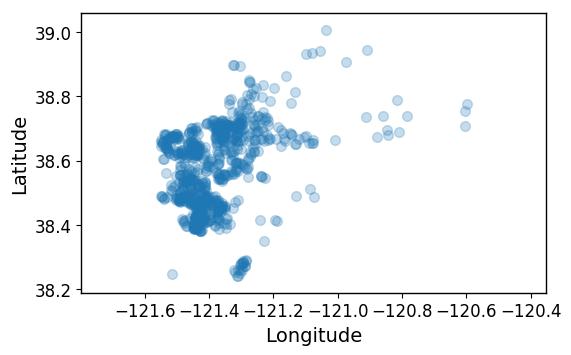

In [27]:
x = housing.rdd.map(lambda row: row.longitude).collect()
y = housing.rdd.map(lambda row: row.latitude).collect()
plt.scatter(x, y, alpha=0.25)
plt.axis('equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [28]:
housing.select('beds', 'baths', 'sqft', 'type_ohe', 'price').show(5)

+----+-----+----+-------------+-----+
|beds|baths|sqft|     type_ohe|price|
+----+-----+----+-------------+-----+
|   2|    1| 836|(3,[0],[1.0])|59222|
|   3|    1|1167|(3,[0],[1.0])|68212|
|   2|    1| 796|(3,[0],[1.0])|68880|
|   2|    1| 852|(3,[0],[1.0])|69307|
|   2|    1| 797|(3,[0],[1.0])|81900|
+----+-----+----+-------------+-----+
only showing top 5 rows



In [29]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=['beds', 'baths', 'sqft'], outputCol="num_features")
df = vecAssembler.transform(housing)

In [30]:
df.show()

+--------------+-----+----+-----+----+-----------+-------------------+------+---------+-----------+-----------+--------+-------------+----------------+
|          city|  zip|beds|baths|sqft|       type|          sale_date| price| latitude|  longitude|total_rooms|type_idx|     type_ohe|    num_features|
+--------------+-----+----+-----+----+-----------+-------------------+------+---------+-----------+-----------+--------+-------------+----------------+
|    SACRAMENTO|95838|   2|    1| 836|Residential|2008-05-21 00:00:00| 59222|38.631913|-121.434879|          3|     0.0|(3,[0],[1.0])| [2.0,1.0,836.0]|
|    SACRAMENTO|95823|   3|    1|1167|Residential|2008-05-21 00:00:00| 68212|38.478902|-121.431028|          4|     0.0|(3,[0],[1.0])|[3.0,1.0,1167.0]|
|    SACRAMENTO|95815|   2|    1| 796|Residential|2008-05-21 00:00:00| 68880|38.618305|-121.443839|          3|     0.0|(3,[0],[1.0])| [2.0,1.0,796.0]|
|    SACRAMENTO|95815|   2|    1| 852|Residential|2008-05-21 00:00:00| 69307|38.616835|-

### Make train-test split

In [31]:
df_train, df_test = df.select('price', 'num_features', 'type_ohe').randomSplit([0.7, 0.3], seed=1234)

### Stardardize

In [32]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="num_features", outputCol="std_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_train)
df_train_std = scaler_model.transform(df_train)
df_test_std = scaler_model.transform(df_test)

### Combine numerical and categorical features

In [33]:
vecAssembler = VectorAssembler(inputCols=['std_features', 'type_ohe'], outputCol="cmb_features")
df_train_std = vecAssembler.transform(df_train_std).select('price', 'cmb_features')
df_test_std = vecAssembler.transform(df_test_std).select('price', 'cmb_features')
df_train_std.show(10)

+-----+--------------------+
|price|        cmb_features|
+-----+--------------------+
|48000|[-2.5281230842039...|
|55422|[-1.3884115156472...|
|56950|[0.89101162146613...|
|59222|[-1.3884115156472...|
|60000|[-2.5281230842039...|
|61000|[-1.3884115156472...|
|61500|[-0.2486999470905...|
|62000|[-1.3884115156472...|
|62050|[-1.3884115156472...|
|63000|[-1.3884115156472...|
+-----+--------------------+
only showing top 10 rows



In [34]:
df_train_std.select('cmb_features').first()

Row(cmb_features=DenseVector([-2.5281, -1.3923, -1.7176, 0.0, 1.0, 0.0]))

### Cache the RDDs

In [35]:
df_train_std = df_train_std.cache()
df_test_std = df_test_std.cache()

### Linear Regression

In [36]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=5, regParam=0.0, solver="normal", featuresCol='cmb_features', labelCol='price')
lr_model = lr.fit(df_train_std)
y_pred_train = lr_model.transform(df_train_std)
y_pred_train.show(5)

+-----+--------------------+------------------+
|price|        cmb_features|        prediction|
+-----+--------------------+------------------+
|48000|[-2.5281230842039...| 89492.64507528633|
|55422|[-1.3884115156472...| 140274.4255243033|
|56950|[0.89101162146613...|204925.05465456034|
|59222|[-1.3884115156472...|139966.05465864472|
|60000|[-2.5281230842039...|109074.19504460657|
+-----+--------------------+------------------+
only showing top 5 rows



In [37]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='price')
evaluator.evaluate(y_pred_train, {evaluator.metricName: "r2"}), evaluator.evaluate(y_pred_train, {evaluator.metricName: "rmse"})

(0.5236247040287527, 82669.76361126584)

In [38]:
y_pred_test = lr_model.transform(df_test_std)
evaluator.evaluate(y_pred_test, {evaluator.metricName: "r2"}), evaluator.evaluate(y_pred_test, {evaluator.metricName: "rmse"})

(0.3727635382344463, 94715.75426396007)

### Random Forest

In [39]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(numTrees=50, seed=42, featuresCol='cmb_features', labelCol='price')
rf_model = rf.fit(df_train_std)
rf_model.featureImportances

SparseVector(6, {0: 0.1608, 1: 0.2156, 2: 0.5783, 3: 0.0206, 4: 0.0161, 5: 0.0087})

In [40]:
y_pred_train = rf_model.transform(df_train_std)
y_pred_train

DataFrame[price: int, cmb_features: vector, prediction: double]

In [41]:
evaluator.evaluate(y_pred_train, {evaluator.metricName: "r2"}), evaluator.evaluate(y_pred_train, {evaluator.metricName: "rmse"})

(0.5720300472908173, 78357.16585589027)

In [42]:
y_pred_test = rf_model.transform(df_test_std)
evaluator.evaluate(y_pred_test, {evaluator.metricName: "r2"}), evaluator.evaluate(y_pred_test, {evaluator.metricName: "rmse"})

(0.48806878611560467, 85568.19662494046)

In [65]:
rf.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Check result with Sklearn

In [43]:
X_train = np.array(df_train_std.rdd.map(lambda row: row.cmb_features.toArray().tolist()).collect())
y_train = np.array(df_train_std.rdd.map(lambda row: row.price).collect())
X_test = np.array(df_test_std.rdd.map(lambda row: row.cmb_features.toArray().tolist()).collect())
y_test = np.array(df_test_std.rdd.map(lambda row: row.price).collect())

In [57]:
X_train.shape

(582, 6)

In [44]:
from sklearn.ensemble import RandomForestRegressor

In [58]:
rf = RandomForestRegressor(n_estimators=50).fit(X_train, y_train)
rf.score(X_train, y_train)

0.90616346466995035

In [59]:
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [46]:
RandomForestRegressor(n_estimators=50).fit(X_train, y_train).score(X_test, y_test)

0.36021878751822312

In [54]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_train = RandomForestRegressor(n_estimators=50).fit(X_train, y_train).predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred_train))

37485.284257793457

In [48]:
y_pred_test = RandomForestRegressor(n_estimators=50).fit(X_train, y_train).predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_test))

96304.544001932009

In [49]:
from sklearn.linear_model import LinearRegression

In [56]:
y_pred_train = LinearRegression().fit(X_train, y_train).predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred_train)), r2_score(y_train, y_pred_train)

(82643.595511323772, 0.52392623781466563)

In [55]:
y_pred_test = LinearRegression().fit(X_train, y_train).predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_test)), r2_score(y_test, y_pred_test)

(94517.203279099398, 0.37539051163151538)